## The Role of AI in Capital Asset Management at DCAMM

Anca Pitigoi, Anuraag Macha, Matthew Branum

College of Professional Studies, Northeastern University

ALY 6080: Integrated Experiential Learning, Winter Term

Dr. Matthew Goodwin

March 29, 2025

In [2]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Import detailed datasets
df1 = pd.read_excel('Raw_plus_Normalization_new001.xlsx')
df2 = pd.read_excel('Raw_plus_Normalization_new002.xlsx')

In [4]:
# Import summary datasets
org_summary = pd.read_csv('Clean Summary Spendings.csv', encoding = 'latin1')

In [ ]:
# Combine files into one df
org_detailed = pd.concat([df1, df2], ignore_index=True)

# Remove redundant files
del df1, df2

In [5]:
# Create new df that would not update the original df
detailed = org_detailed.copy()
summary = org_summary.copy()

### Clean the summary table
A significant portion of the dataset contains redundant features, primarily due to multiple representations of the same information. For instance, project cost is broken down into design, construction, and furnishing costs, which would introduce multicollinearity in machine learning models. To mitigate this, redundant variables will be removed.

In [6]:
# Standardize de column names
rename_dict = {
    "95% Con Month": "con_month_95pct_spent",
    "City": "city",
    "Construction Type": "construction_type",
    "County": "county",
    "Description": "description",
    "Bucket Category": "bucket_category",
    "Simple Bucket": "simple_bucket",
    "Phase": "phase",
    "Project ID": "PID",
    "TPC": "total_project_cost",
    "Duration(Months)Construction": "dur_construction_months",
    "Duration(Months)Design": "dur_design_months",
    "Duration(Months)Other": "dur_other_months",
    "Duration(Months)LandAcq": "dur_land_acq_months",
    "Duration(Months)FE": "dur_fe_months",
    "Construction Costs at Final": "construction_costs_final",
    "Design Costs at Final": "design_costs_final",
    "Other Costs at Final": "other_costs_final",
    "Land Acquisition Costs at Final": "land_acquisition_costs_final",
    "F&E Costs at Final": "fe_costs_final",
    "Agy": "agency",
    "Capital Project Category": "capital_project_category",
    "TPC Cat Num": "tpc_category",
    "TPC Category": "tpc_category_name",
    "Construction_Start_Date": "construction_start_date",
    "Construction_End_Date": "construction_end_date",
    "Start(Month)Construction": "start_month_construction",
    "End(Month)Construction": "end_month_construction",
    "Design_Start_Date": "design_start_date",
    "Design_End_Date": "design_end_date",
    "Start(Month)Design": "start_month_design",
    "End(Month)Design": "end_month_design",
    "Other_Start_Date": "other_start_date",
    "Other_End_Date": "other_end_date",
    "Start(Month)Other": "start_month_other",
    "End(Month)Other": "end_month_other",
    "LandAcq_Start_Date": "land_acq_start_date",
    "LandAcq_End_Date": "land_acq_end_date",
    "Start(Month)LandAcq": "start_month_land_acq",
    "End(Month)LandAcq": "end_month_land_acq",
    "FE_Start_Date": "fe_start_date",
    "FE_End_Date": "fe_end_date",
    "Start(Month)FE": "start_month_fe",
    "End(Month)FE": "end_month_fe",
    "Construction Costs at 95% Construction": "construction_costs_95pct",
    "Design Costs at 95% Construction": "design_costs_95pct",
    "Other Costs at 95% Construction": "other_costs_95pct",
    "Land Acquisition Costs at 95% Construction": "land_acquisition_costs_95pct",
    "F&E Costs at 95% Construction": "fe_costs_95pct"
}

summary.rename(columns=rename_dict, inplace=True)

In [7]:
#Remove extra 4 rows
summary = summary.drop(summary.index[157:161])

#Remove extra 2 empty columns
summary = summary.drop(columns= summary.columns[-2:])

It is common practice to standardize the column names by removing the spaces and special characters.

#### Data type validation
All of the costs are imported as objects due to the $ and comma signs. This will be fixed by creating a function to convert to numerical features. We will leave other duration months as float because they contain missing values.

In [8]:
summary.info()

# Fix the currency-formatted strings to float
def clean_currency(value):
    try:
        return float(value.replace('$', '').replace(',', '').replace('(', '-').replace(')', ''))
    except AttributeError:
        return value #Return the value as-is if it's not a string, especially for NAs

# Apply the function to the affected columns
summary["total_project_cost"] = summary["total_project_cost"].apply(clean_currency)
summary['construction_costs_final'] = summary['construction_costs_final'].apply(clean_currency)
summary['construction_costs_95pct'] = summary['construction_costs_95pct'].apply(clean_currency)
summary['design_costs_final'] = summary['design_costs_final'].apply(clean_currency)
summary['design_costs_95pct'] = summary['design_costs_95pct'].apply(clean_currency)
summary['other_costs_final'] = summary['other_costs_final'].apply(clean_currency)
summary['other_costs_95pct'] = summary['other_costs_95pct'].apply(clean_currency)
summary['land_acquisition_costs_final'] = summary['land_acquisition_costs_final'].apply(clean_currency)
summary['land_acquisition_costs_95pct'] = summary['land_acquisition_costs_95pct'].apply(clean_currency)
summary['fe_costs_final'] = summary['fe_costs_final'].apply(clean_currency)
summary['fe_costs_95pct'] = summary['fe_costs_95pct'].apply(clean_currency)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   con_month_95pct_spent         157 non-null    float64
 1   agency                        157 non-null    object 
 2   city                          157 non-null    object 
 3   construction_type             157 non-null    object 
 4   county                        157 non-null    object 
 5   description                   157 non-null    object 
 6   bucket_category               157 non-null    object 
 7   simple_bucket                 157 non-null    object 
 8   capital_project_category      136 non-null    object 
 9   phase                         157 non-null    object 
 10  PID                           157 non-null    object 
 11  total_project_cost            157 non-null    object 
 12  tpc_category                  157 non-null    float64
 13  tpc_c

In [9]:
# Assign the right data type
summary['con_month_95pct_spent'] = pd.to_numeric(summary['con_month_95pct_spent']).astype(int)
summary['tpc_category'] = pd.to_numeric(summary['tpc_category']).astype(int)

summary['construction_start_date'] = pd.to_datetime(summary['construction_start_date']).dt.date
summary['construction_end_date'] = pd.to_datetime(summary['construction_end_date']).dt.date
summary['start_month_construction'] = pd.to_numeric(summary['start_month_construction']).astype(int)
summary['end_month_construction'] = pd.to_numeric(summary['end_month_construction']).astype(int)
summary['dur_construction_months'] = pd.to_numeric(summary['dur_construction_months']).astype(int)

summary['design_start_date'] = pd.to_datetime(summary['design_start_date']).dt.date
summary['design_end_date'] = pd.to_datetime(summary['design_end_date']).dt.date
# we cannot convert the start/end months into int because there are missing values.

summary['other_start_date'] = pd.to_datetime(summary['other_start_date']).dt.date
summary['other_end_date'] = pd.to_datetime(summary['other_end_date']).dt.date

summary['land_acq_start_date'] = pd.to_datetime(summary['land_acq_start_date']).dt.date
summary['land_acq_end_date'] = pd.to_datetime(summary['land_acq_end_date']).dt.date

summary['fe_start_date'] = pd.to_datetime(summary['fe_start_date']).dt.date
summary['fe_end_date'] = pd.to_datetime(summary['fe_end_date']).dt.date

In [10]:
# Check categories mispellings
summary['city'].value_counts()

# Correct cities
summary.loc[summary['city'].str.contains(
    'Bosjamplai|Boston - Roxbu|Bosroxbury|Boston - Dorch', case = False, na = False),'city'] = 'Boston'

summary.loc[summary['city'].str.contains(
    'Springfiel', case = False, na = False), 'city'] = 'Springfield'

summary['construction_type'].value_counts()

summary['county'].value_counts()

# Set the option to display all rows
pd.set_option('display.max_rows', None)

summary.groupby('bucket_category')['PID'].count()

bucket_category
Admin Renovation                   3
Athletic                           3
Classroom                          2
Corrections Energy                 1
Corrections Expansion              2
Corrections HVAC                   2
Corrections Reno                   1
Corrections Repair                 1
Corrections Roof                   2
Court Elevator                     1
Court HVAC                         1
Court Reno                         3
Elevator Renovation                1
Energy Solar                       2
Energy Turbine                     2
Energy/Infrastructure              9
Energy/Water                       9
Expansion                          1
Exterior Envelope                  3
Fire Training                      2
HE - Reno                         21
HE HVAC                            1
He HVAC                            1
Higher Ed Office/Admin Space       1
Historic Elevator                  1
Historic Energy/Water              1
Historic Interior Reno

Mispelled cities were found and corrected as they were causing more categories to form. No other categories had mispelled or duplications.

The buckets for the category contain mispelled duplicate categories. In certain instances, the bucket is incorrectly assigned a category that does not meet the description of the project. Moreover, some of the categories can be merged. This task is part data cleaning, and part feature engineering due to the merging of the categories.

#### Feature engineering & data selection

In [11]:
# Create a new summarized category bucket for easier comparision of the projects

category_mapping = {
    # Renovation-related projects
    "HE - Reno": "School",
    "Historic Interior Renovation": "Historic Interior",
    "Historic Energy/Water": "Utility",
    "Hospital Inpatient Renovation": "Hospital",
    "Youth Reno": "School",
    "Admin Renovation": "Office",
    "Court Reno": "Court",
    "doc archives Reno": "Specialty Facility",
    "Exterior Envelope": "Exterior Envelope",
    "Elevator Renovation": "Elevator",
    "Corrections Repair": "Detention Facility",
    "Interior Renovation": "Court", #This specific project was for the court house, only one in the dataset
    "Office/Admin ": "Office",
    
    # Energy and Infrastructure projects
    "Energy/Water": "Utility",
    "Energy/Infrastructure": "Utility",
    "Energy Solar": "Utility",
    "Energy Turbine": "Utility",
    "Corrections Energy": "Utility",
    "Infrastructure - Sewage": "Utility",
    "Infrastructure Roof": "Roof",
    "Mech/Electrical Infrastructure": "Utility",
    "Mechanical Electrical": "Utility",
    "Mechanical Electrical ": "Utility",
    "Corrections Energy ": "Utility",
    "Infrastructure Renovation": "Utility",
    "Infrastructure Electrical": "Utility",
    "Veteran Repair": "Utility", #based on Capital Project Category attribute
    
    # Hospital or healthcare-related
    "Hopsital Inpatient Renovation": "Hospital",  # corrected typo
    "Hospital Electrical": "Utility",
    "Hospital Life Safety": "Life Safety",
    "New Hospital Inpatient": "Hospital",
    "Hospital External Repair": "Exterior Envelope",
    "Hospital Interior Reno": "Hospital",
    
    # Education / Science
    "Science/Classroom": "Laboratory",
    "Higher Ed Office/Admin Space": "Office",
    
    # Repairs and Maintenance
    "Masonry": "Masonry",
    "Exterior Masonry Repairs": "Masonry",  # if present in description, adjust accordingly
    "Tech Infrastructure": "Utility", #based on Capital Project Category attribute, and tpc category
    "Corrections Roof": "Roof",
    
    # Other specific categories
    "Lifesafety": "Life Safety",
    "Veteran Life Safety": "Life Safety",
    "Historic Repair": "Historic Interior",
    "Historic Elevator": "Elevator",
    "Office/Admin": "Office",
    "Maintenance Facility": "Specialty Facility", #since it's more of a specialized room, like fire/police training rooms
    "Laboratory": "Laboratory",
    "Laboratory Roof": "Roof",
    "Fire Training": "Specialty Facility", #These are highly specilized rooms
    "Police Training": "Specialty Facility",
    "Athletic": "Specialty Facility",
    "New Youth": "School",
    "Youth Roof": "Roof",
    "doc archives HVAC": "HVAC",
    "He HVAC": "HVAC",
    "HE HVAC": "HVAC",
    "Military Facility": "Specialty Facility",
    "New Corrections": "Detention Facility",
    "Corrections Expansion": "Detention Facility",
    "Corrections Reno": "Detention Facility",
    "New Police": "Specialty Facility",
    "New Court": "Court",
    "Expansion": "Specialty Facility", #the only project categorized as expansion is a cemetery expansion
    "IT Data Center": "Specialty Facility",
    "Classroom": "School",
    "Court Elevator": "Elevator",
    "Court HVAC": "HVAC",
    "Corrections HVAC" : "HVAC",
    "Parking": "Specialty Facility"
}

# Create a new column with the summarized categories.
summary["summarized_category"] = summary["bucket_category"].map(category_mapping)

In [12]:
summary.groupby('summarized_category')['PID'].count()

summarized_category
Court                  7
Detention Facility     5
Elevator               3
Exterior Envelope      5
HVAC                   6
Historic Interior      5
Hospital               6
Laboratory            17
Life Safety            5
Masonry                3
Office                 6
Roof                   6
School                25
Specialty Facility    16
Utility               42
Name: PID, dtype: int64

In [13]:
# Create total duration project feature
duration_cols = ['dur_construction_months',  'dur_design_months',
       'dur_other_months', 
       'dur_land_acq_months', 'dur_fe_months']

In [14]:
# Finding the last month between all phases, that is the total duration of the project
summary['total_duration_months'] = (
    summary[[
        'end_month_construction', 'end_month_design', 'end_month_other', 
        'end_month_land_acq', 'end_month_fe']].max(axis=1) - 
    summary[[
        'start_month_construction', 'start_month_design', 'start_month_other', 
        'start_month_land_acq', 'start_month_fe']].min(axis=1)
)

From all the project descriptions (description, bucket_category, simple_bucket), the feature that does not give too many details or too few, is the bucket_category. The rest will be discarded from this model. 

In [15]:
summary = summary.drop(columns = ['description', 'simple_bucket'])

### Clean the detailed dataset

In [16]:
# Identify columns with 100% missing values 
detailed.isnull().sum() / len(detailed) * 100

# which columns have 100% missing values?
null_cols = detailed.columns[detailed.isnull().all()].tolist()
print(detailed.columns[detailed.isnull().all()])

Index(['commodity', 'commodity_name', 'unit_of_measure',
       'unit_of_measure_descr'],
      dtype='object')


In [17]:
# Find columns with one unique value
unique_value_cols = [col for col in detailed.columns
                        if detailed[col].nunique() == 1]

print(unique_value_cols)

['doc_comm_line_no', 'doc_phase_code', 'doc_phase_name', 'program_period', 'expense_bucket_identifier', 'expense_bucket_name']


After reviewing each of the columns with unique values, it was determined that they are safe to be removed from the analysis since they do not provide good insights. All program periods are Extended Program Period, and the feature program_period_name is also redundant since it contains the same data as program_period. The values are slighly changed due to mispelling. All values in expense_bucket_identifier and expense_bucket_name refer to cash expenses.

In [18]:
detailed = detailed.drop(columns = unique_value_cols + null_cols)

In [19]:
# Identify columns with more than 5% missing values
detailed.columns[(detailed.isnull().sum() / len(detailed)) * 100 >5]

Index(['doc_unit', 'doc_name', 'doc_descr', 'vendor_invoice_no',
       'vendor_invoice_date', 'service_from_date', 'service_to_date',
       'activity_name', 'actg_line_descr', 'ref_doc_code',
       'ref_doc_department_code', 'ref_doc_identifier', 'vendor_customer_code',
       'tin', 'legal_name', 'alias_name'],
      dtype='object')

In [20]:
detailed.doc_name.value_counts() # this info won't probably be included in the ML
detailed.activity_name.value_counts() # can be valuable
detailed.actg_line_descr.value_counts() # can be valuable

look = detailed[detailed['activity_name'].notnull() & detailed['actg_line_descr'].notnull()]

In [21]:
missing_5pct = ['doc_unit', 'doc_name', 'doc_descr', 'vendor_invoice_no',
       'vendor_invoice_date', 'service_from_date', 'service_to_date',
       'ref_doc_code', 'ref_doc_department_code', 'ref_doc_identifier', 
       'vendor_customer_code', 'tin', 'alias_name']

detailed = detailed.drop(columns= missing_5pct)

In [22]:
# Look further into distinct values
detailed.describe(include= 'object') #some columns need to be manually inspected for valuable information

,government_branch_name,cabinet_name,department,department_name,unit,unit_name,doc_category,doc_type,doc_code,doc_department_code,...,program_name,phase,phase_name,doc_created_by,doc_last_modified_by,Source_system,PID,PayClass,Month,ProgPhase
count,47741,47741,47741,47741,47741,47741,47741,47741,47741,47741,...,47741,47741,47392,47741,47741,47741,47741,47741,47741,47741
unique,2,8,40,42,63,77,5,6,12,18,...,281,54,48,40,45,2,158,5,12,634
top,EXECUTIVE BRANCH,EXECUTIVE OFFICE FOR ADMINSTRATION & FINANCE,DCP,CAPITAL ASSET MANAGEMENT and MAINTENANCE DIVISION,DCPC,Capital Asset Mgmnt-Capital Accounts,AP,AD,EFT,CTR,...,New Psychiatric Facility-DMH,DC1,DC1,System Admin,System Admin,CIW-DCP,DMH0501,Other,July,DMH0501-DC1
freq,45904,42462,42447,42376,23024,23024,34849,34849,29409,38604,...,1806,23038,23038,47420,30798,42447,1850,19574,4681,1641


It is noticed from summarization of character variables that the information was pulled from multiple tables. Most of the character variables include information about the invoice lines, invoice creator, and the document type. The following columns will be removed:
- budget_fiscal_year is the same as fiscal year, therefore redundant
- government: government_branch and government_branch_name is removed due to lack of information. Also there are only 2 unique values.
- cabinet_name, cabinet, department, department_name, unit, unit_name don't provide valuable info for ML. 
- anything that starts with doc doesn't qualify as good predictor: 'doc_category', 'doc_type', 'doc_code', 'doc_department_code',
       'doc_identifier', 'doc_version_no', 'doc_actg_line_no',
       'doc_pstng_line_no', 'doc_vendor_line_no', 'doc_function_code',
       'doc_function_code_name'.
- appropriation: the only feature in this category that is relevant is appropriation_name, the rest is redundant.
- fund: information where the money come from is generally not relevant to forsee the cost.
- object: object could be useful as categorization, but for one-hot encoding we will automate it with code. For now, the most relevant to stay would be the object_name. Object class name is a little more categorical than the object name.
- activity: from the activity group, the most detailed attribute is actg_line_descr, but it contain 45% missing values. These could be imputed from activity name (has 4% missing values). Activity attribute does not bring anything relevant, the rest will be left for now.
- reference: none of these attributes are useful.
- program: only the program name remains in case it provides more details than object and activity features. program is duplicate for PID.
- phase and phase name are the same. phase will be kept.
- document: anything related when the invoice was created in the system is redundant, besides 'doc_last_modified_date' because the fiscal year is not the same as when the payment went out for all instances.
- payment lag: not sure what signifies, but it doesn't seem relevant.
- source sytemn  and DCAFnum are not important for cost forecasting.
- first pay gives information about when the project started to have payments. It would be useful only if we did not have the fiscal year and period.
- project month gives information about in which month of the project duration that specific payment was made.
- 95Expend, not sure what it is, but will keep it for now.
- progphase is a concatenation of project id and phase. It can be removed.
- PayClass_First_Pay gives info about each payclass, but it is redundant.
- PayClass Month Adjusted, not sure what is this column adjusted for.

In [23]:
redundant_cols = ['budget_fiscal_year', 'fiscal_year', 'fiscal_period',
                  'government_branch_name', 'government_branch', 'cabinet_name', 'cabinet',
                  'department', 'department_name', 'unit', 'unit_name', 
                  'payment_lag',
                  'doc_category', 'doc_type', 'doc_code', 'doc_department_code', 'doc_identifier', 'doc_version_no', 'doc_actg_line_no',
                   'doc_pstng_line_no', 'doc_vendor_line_no', 'doc_function_code', 'doc_function_code_name',
                  'appropriation', 'appropriation_type', 'appropriation_type_name',
                  'fund', 'fund_name', 'sub_fund', 'sub_fund_name',
                  'object', 'object_class', 'object_class_name',
                  'activity',
                  'ref_vendor_line_no', 'ref_commodity_line_no', 'ref_actg_line_no', 'reference_type', 'reference_type_name',
                  'program_period_name', 'major_program', 'major_program_name', 'program',
                  'phase_name',
                  'doc_created_by', 'doc_created_on', 'doc_last_modified_by',
                  'acceptance_date', 'date_to_warehouse', 'DW_Loaddate', 'Source_system', 'DCAFnum',
                  'First_Pay', 'ProgPhase', 'PayClass_First_Pay'
                  ]

detailed = detailed.drop(columns= redundant_cols)

In [24]:
# Extract the year of when the charge was paid, which would mean perhaps when the document was last modified.
detailed['pay_year'] = detailed['doc_last_modified_date'].dt.year

#### Inflation adjusted prices

Because each city has a different inflation index, we will import from the summary dataset the city. Since not all cities have an index in the provided table by DCAMM, we will use the average for that year for the cities that do not have the corresponding index. Moreover, if the payment was made between Jan-Jun, previous year index is used, if July-Dec next year.

In [25]:
# Import cities from the summary dataset and create dictionary for inflation adjustments
city_index = summary[['PID', 'city']]
detailed = detailed.merge(city_index, left_on="PID", right_on="PID", how="left") # merge datasets

# UMD1901 is for UMass but it is not located in the city index, so it will be inputed here. We know UMass is in Boston.
detailed.loc[detailed['PID'] == 'UMD1901', 'city'] = 'Boston'

# Merge the city inflation index
inflation_index = pd.read_csv('Inflation adjusted index.csv')
inflation_index = inflation_index.melt(id_vars = ['Places'], var_name = 'year', value_name= 'index_value')
inflation_index['year'] = inflation_index['year'].astype(int) #Convert year to integer

# Change the month to integer
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}

# Convert the Month column from Jan, Feb, etc. to numbers
detailed["Month"] = detailed["Month"].map(month_mapping)

# Assign the correct city index according to DCAMM instructions. If payment was made between Jan-Jun, we use previous year, if July-Dec next year.
def city_index_function(row):
    year = row['pay_year'] - 1 if row['Month'] <= 6 else row['pay_year']
    index_row = inflation_index[(inflation_index['year'] == year) & (inflation_index['Places'] == row['city'])]

    # If there is no index for the actual city of the project, we'll use the state's average index for that year
    if index_row.empty:
        return inflation_index[inflation_index['year'] == year]['index_value'].mean().round(1)
    
    return index_row['index_value'].values[0] # this takes the exact city index

detailed['city_index'] = detailed.apply(city_index_function, axis = 1)

# Calculate the city inflation adjustments
def city_2025_index(city):
    """Assign the 2025 index for a specific city or use the average if unavailable"""
    index_row = inflation_index[(inflation_index['year'] == 2025) & (inflation_index['Places'] == city)]
    return index_row['index_value'].values[0] if not index_row.empty else inflation_index[inflation_index['year'] == 2025]['index_value'].mean().round(1)

detailed['2025_index'] = detailed['city'].apply(city_2025_index)

# Adjust the costs based on the formula: Multiply the past dollar amount by the current CPI and 
    # divide it by the past CPI (when the original dollar amount was recorded).

detailed['adjusted_cash_expense'] = (detailed['cash_expense_amount'] * (detailed['2025_index'] / detailed['city_index'])).round(2)

In [26]:
# Create new total project price
detailed['adjusted_tpc'] = detailed.groupby('PID')['adjusted_cash_expense'].transform('sum')

# After the total price is adjusted for inflation, '%TPC', '%PayClass', 'PayClassSum.1' are not relevant anymore. They need to be updated in order to be used. 
    # So, for now we will discard them from the analysis. They can be brought back by grouping by PayClass.

detailed = detailed.drop(columns= ['%TPC', '%PayClass', 'PayClassSum.1', 'city_index', '2025_index', 'PayClass Month Adjusted', '95Expend'])

In [27]:
del city_index # no longer needed

In [28]:
# Object name give info regarding the nature of the expense. Some names can be standardized and combined.
object_name_mapping = {
    "Electricity - Supply": "Electricity",
    "Office Furnishings": "Furnishing",
    "Facility Furnishings": "Furnishing",
    "Initial Furnishings & Equipment Purchases": "Furnishing",
    "Office Furnishings Maintenance & Repair": "Furnishing",
    "Appraisers": "Auctioneers/Appraisers",
    "Engineering, Research and Scientific Services": "Engineering, Research & Scientific Services",
    "Facility Infrastructure Maintenance & Repair Tools & Supplie": "Facility Infrastructure Maintenance, Repair Tools & Supplies",
    "Fuel For Buildings": "Fuel",
    "Fuel For Vehicles": "Fuel",
    "Farm And/Or Garden Expenses & Supplies": "Farm/Garden Expenses & Supplies",
    "Garden Expenses, Tools and Supplies": "Farm/Garden Expenses & Supplies",
    "Horizon/Vert Constr Related S&J - Tax Rep to Claimant - Clai": "Settlements/Judgements", # based on activity_name
    "Highway Horizontal/Lateral Construction": "Highway",
    "Highway Horizontal/Lateral Maintenance & Improvements": "Highway",
    "Highway/Lateral Structure Planning/Engineering": "Highway",
    "Information Tech (IT) Equipment Maintenance & Repair": "IT Services",
    "Information Technology (IT) Cabling": "IT Services",
    "Information Technology (IT) Contract Services": "IT Services",
    "Information Technology (IT) Equip Rental Or Lease": "IT Services", # not that many observations when pivot table is performed, therefore combining
    "Information Technology (IT) Equipment": "IT Services",
    "Information Technology (IT) Professionals": "IT Services",
    "Information Technology (IT) Temp Staff Augmentation Profs": "IT Services",
    "Late Penalty Interest": "Fees, Fines, Licenses, Permits & Chargebacks",
    "Law Enforcement": "Law Enforcement Equip & Supplies",
    "Law Enforcement & Security Equipment": "Law Enforcement Equip & Supplies",
    "Law Enforcement & Security Supplies": "Law Enforcement Equip & Supplies",
    "Legal Support Services": "Attorneys/Legal Services",
    "Major Building Maintenance and Land Improvements": "Blding Constr, Maint & Land Improvement",
    "Major Constr, Renovation, Blding Alteration & Land Imprvmnts": "Blding Constr, Maint & Land Improvement",
    "Major New Building/Vertical Structure Construction": "Blding Constr, Maint & Land Improvement",
    "New Construction, Major Renovation, Building Alteration and": "Blding Constr, Maint & Land Improvement",
    "Reim Trav/Exp For Consultant Services": "Travel/Other",
    "Reimb Trav & Other Exp For Operational Services": "Travel/Other",
    "Reimb Travel/Other Expenses CC Special Contract/Employee": "Travel/Other",
    "Reimbursement for Travel/Other Expense Infras Projects": "Travel/Other",
    "In-State Travel": "Travel/Other",
    "S&J:Tax Reportable:non-employee:sole payee": "Settlements/Judgements", # based on activity_name
    "Salaries: Inclusive": "Salaries",
    "Salaries:Regular": "Salaries",
    "Shift Differential Pay": "Salaries",
    "Software & Information Technology Licenses (IT)": "IT Services",
    "Telecommunications Services - Voice": "Telecom",
    "Telecommunications Services Data": "Telecom",
    "Temp Use Space/Confer-Incidental Includes Reservation Fees": "Space Rental",
    "Office Equipment Rental or Lease": "Office Equipment", # 0 spendings
    "Overtime Pay": "Salaries"
}

detailed["object_name"] = detailed["object_name"].replace(object_name_mapping)

# Further mapping
object_name_mapping = {
'Archivists/Librarians/Record Managers': 'Professional Services',
'Building/Land Improvements & Land Maintenance': 'Blding Constr, Maint & Land Improvement',
'Building/Vertical Structure Construction': 'Blding Constr, Maint & Land Improvement',
'Central Reprographic Chargeback': 'Fees, Fines, Licenses, Permits & Chargebacks',
'Client & Resident Wages': 'Furnishing & Maintenance/Repair',
'Construction Bonus': 'IT Services',
'Construction Management': 'Professional Services',
'Financial Services': 'Professional Services',
'Food, Beverages & Preservation': 'Misc',
'Furnishings Maintenance & Repair': 'Furnishing & Maintenance/Repair',
'Grants To Public Entities': 'Misc',
'Heavy Equipment Rental/Lease': 'Equipment Rental',
'Instructors/Lecturers/Trainers': 'Professional Services',
'Kitchen & Dining Supplies': 'Misc Supplies',
'Laboratory Supplies': 'Misc Supplies',
'Licensed Or Professional Tradespeople': 'Professional Services',
'Live Animals & Related Supplies': 'Misc Supplies',
'Manufacturing Supply & Materials & Raw Materials': 'Misc Supplies',
'Medical Equipment Maintenance & Repair': 'Medical Services, Equip & Supplies',
'Medical/Hlth Service Provided by Individuals Not Within Orgs': 'Medical Services, Equip & Supplies',
'Motorized Vehicle Equipment': 'Equipment',
'Planners': 'Professional Services',
'Relocation Costs Land Taking': 'Land Acquisition and Eminent Domain',
'Secretariat Central Services Chargeback': 'Fees, Fines, Licenses, Permits & Chargebacks',
'Temporary Help Services': 'Professional Services',
'Transportation Operating Agreements': 'Equipment',
'Clothing & Footwear': 'Misc Supplies',
'Exhibits/Displays': 'Furnishing & Maintenance/Repair',
'Farm/Garden Expenses & Supplies': 'Misc Supplies',
'Health and Safety Services': 'Medical Services, Equip & Supplies',
'Lawn and Grounds Equipment': 'Equipment',
'Library & Teaching Supplies & Materials': 'Misc Supplies',
'Medical & Surgical Supplies': 'Medical Services, Equip & Supplies',
'Police Detail': 'Professional Services',
'Snow Removal and Groundskeeping Services': 'Professional Services',
'Television Broadcasting Equipment': 'Equipment',
'Programmatic Facility Equipment Rental or Lease': 'Equipment Rental',
'Exigent Job Related Expenses': 'Salaries',
'Fringe Benefits Reimbursement': 'Fringe Benefits',
'National Defense & Public Order & Security & Non Medical Saf': 'Professional Services',
'Cleaners/Janitors': 'Housekeeping Services & Supplies',
'Laundry & Cleaning Supplies': 'Housekeeping Services & Supplies',
'Office Equipment': 'Office Supplies & Equipment',
'Educational Equipment': 'Equipment',
'Management Consultants': 'Professional Services',
'Testing Firms': 'Professional Services',
'Medical Equipment': 'Medical Services, Equip & Supplies',
'Contracted Faculty': 'Professional Services',
'Office & Administrative Supplies': 'Office Supplies & Equipment',
'Programmatic Facility Equipment': 'Equipment',
'Facility Infrastructure Maintenance, Repair Tools & Supplies': 'Non-Major Facility Infrastructure Maintenance and Repair',
'Auxiliary Services': 'Professional Services',
'Furnishing': 'Furnishing & Maintenance/Repair',
'Fringe Benefit Cost Recoupment': 'Fringe Benefits'
}

detailed["object_name"] = detailed['object_name'].replace(object_name_mapping)

In [29]:
# To keep the notebook smaller in size, temporary variables can be deleted
del missing_5pct, look, redundant_cols, month_mapping, unique_value_cols, null_cols, rename_dict, duration_cols

### Exploratory Data Analysis

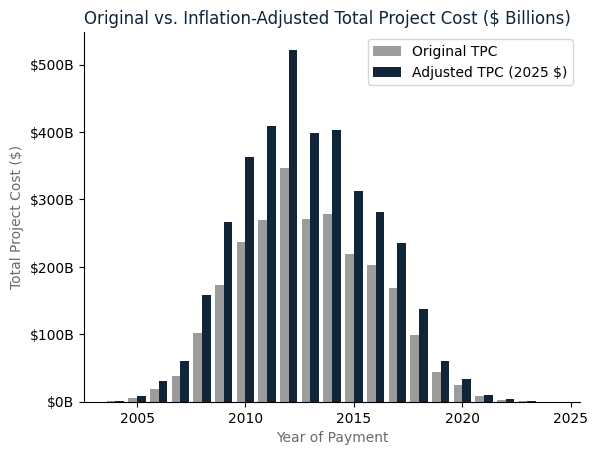

In [30]:
# Aggregate total costs per year
cost_per_year = detailed.groupby("pay_year")[["TPC.1", "adjusted_tpc"]].sum().reset_index()

# Set up the bar width
bar_width = 0.4
years = cost_per_year["pay_year"]

# Plot the bar chart
plt.bar(years - bar_width/2, cost_per_year["TPC.1"], width=bar_width, label="Original TPC", color = '#9C9C9C')
plt.bar(years + bar_width/2, cost_per_year["adjusted_tpc"], width=bar_width, label="Adjusted TPC (2025 $)", color = '#112539')

# Formatting the plot
plt.xlabel("Year of Payment", color='#6B6B6B')
plt.ylabel("Total Project Cost ($)", color='#6B6B6B')
plt.title("Original vs. Inflation-Adjusted Total Project Cost ($ Billions)", x=0, ha='left', color='#112539')
plt.legend()
sns.despine()

# Format y-axis labels as $xB
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${x/1e9:,.0f}B'))

# Show the plot
plt.show()

How many projects does DCAMM complete per year?

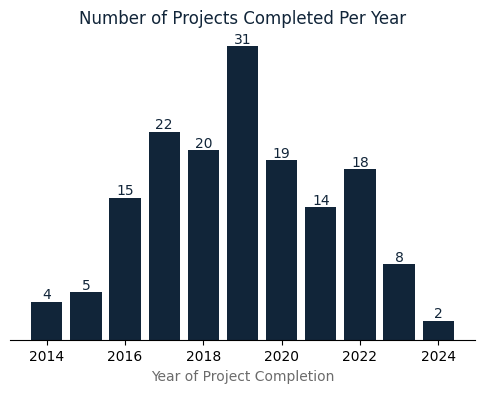

In [31]:
# Find the most recent pay_year for each PID
latest_year = detailed.groupby("PID")["pay_year"].max().reset_index()

# Count the number of unique projects completed per year
projects_per_year = latest_year["pay_year"].value_counts().reset_index()
projects_per_year.columns = ["pay_year", "num_projects"]
projects_per_year = projects_per_year.sort_values("pay_year")

# Step 3: Plot the number of projects completed per year
plt.figure(figsize=(6, 4))
bars = plt.bar(projects_per_year["pay_year"], projects_per_year["num_projects"], color="#112539")

# Add labels on top of bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of bar)
        bar.get_height(),  # Y-coordinate (top of bar)
        f"{int(bar.get_height())}",  # Convert to integer and display as text
        ha="center",  # Center-align text
        va="bottom",  # Position text just above the bar
        fontsize=10, 
        color="#112539"
    )

# Formatting the plot
plt.xlabel("Year of Project Completion", color='#6B6B6B')
plt.title("Number of Projects Completed Per Year", color='#112539')
sns.despine()
plt.gca().spines['left'].set_visible(False)  # Remove the left line
plt.gca().tick_params(left=False)  # Remove y-axis ticks
plt.yticks([])  # Remove y-axis ticks

# Show the plot
plt.show()

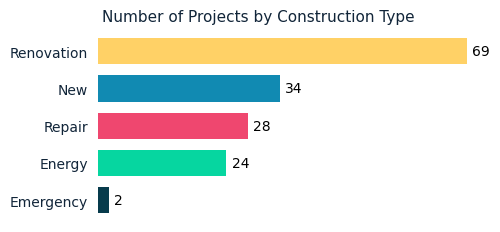

In [32]:
# Calculate counts per construction type
counts = summary['construction_type'].value_counts()

plt.figure(figsize=(5, 2.5))
bars = plt.barh(counts.index, counts.values, 
                color=['#FFD166', '#118AB2', '#EF476F', '#06D6A0', '#073B4C'],
                height= 0.7)

# Add numbers to the right of the bars
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             str(int(bar.get_width())), va='center')

# Customize the chart
plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)  # Remove the top line
plt.gca().spines['right'].set_visible(False)  # Remove the right line
plt.gca().spines['left'].set_visible(False)  # Remove the left line 
plt.gca().spines['bottom'].set_visible(False)  # Remove the bottom line for a cleaner look
plt.gca().tick_params(left=False)  # Remove y-axis ticks
plt.xlabel("")  # Remove x-axis label
plt.xticks([])  # Remove x-axis ticks
plt.yticks(color='#112539')
plt.title("Number of Projects by Construction Type", fontsize=11, x=0.01, ha = 'left', color ='#112539')

plt.show()

In [33]:
del cost_per_year, bar_width, years, latest_year, projects_per_year, bars, counts

Based on the summary dataset, reveals that the majority of projects undertaken by DCAMM between 2004 and 2024 were renovations, followed by new construction. The predominance of renovation projects suggests a strong focus on upgrading and maintaining existing infrastructure rather than expanding through new developments. Notably, only two emergency projects were recorded during this period, which indicates that the organization prioritizes proactive maintenance and long-term planning, minimizing the need for urgent, reactive interventions.

In [34]:
unique_adjusted_tpc = detailed[['PID', 'adjusted_tpc']].drop_duplicates() #otherwise the merge will bring in all ~47K records

# Merge into summary
summary = summary.merge(unique_adjusted_tpc, on='PID', how='left')

SOMETHING WRONG WITH THE GRAPH

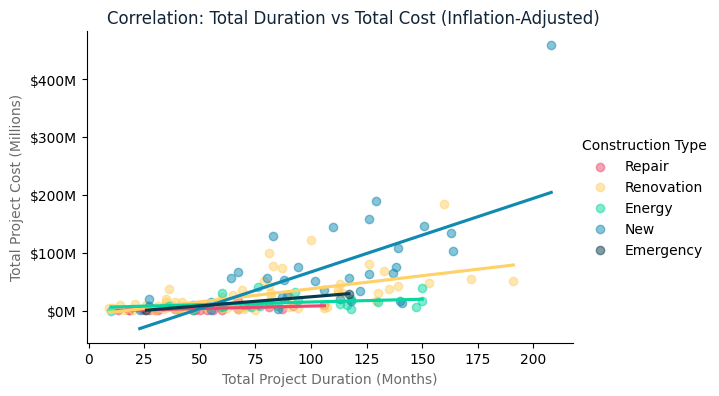

In [35]:
import matplotlib.ticker as ticker

# Create scatter plot with regression line
g = sns.lmplot(data=summary,
             x="total_duration_months",
             y="adjusted_tpc",
            hue = 'construction_type',
            palette=['#EF476F', '#FFD166', '#06D6A0', '#118AB2', '#073B4C'],
            scatter_kws={"alpha": 0.5},
            ci=None,  # Disable the 95% confidence interval 
            height=4, aspect=1.4, legend=False)

# Format axes and title
g.set_xlabels("Total Project Duration (Months)", color='#6B6B6B')
g.set_ylabels("Total Project Cost (Millions)", color='#6B6B6B')
plt.suptitle("Correlation: Total Duration vs Total Cost (Inflation-Adjusted)", x=0.125, ha='left', color='#112539')
g.add_legend(title='Construction Type')

# Format y-axis labels as $xM
g.ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'${x/1e6:,.0f}M'))

# Remove the top and right borders for a cleaner look
sns.despine()
plt.show()

Overall, there is a positive relationship between total project duration and total project cost. The slopes of the regression lines differ noticeably by construction type, indicating that some project categories see a faster rise in total cost as duration increases. A steeper slope (New projects) means costs escalate more sharply with each additional month, while a flatter slope (Energy projects) suggests costs grow more gradually over time. It is good to mention that the category "Emergency" contains only two projects, therefore the regression line is unreliable and does not represent any underlying trend.

From the same graph, it can also be seen that there is a potential outlier within the new projects. This will be further investigated.

In [36]:
anca_summary = summary.copy() # in order to work together on the same file

# Keep and Move columns to facilitate easier interpretation
anca_summary = anca_summary[['PID', 'construction_type','summarized_category','phase', 'county', 'city',
        'con_month_95pct_spent', 'adjusted_tpc', "total_project_cost", 'total_duration_months',
        'design_costs_final', 'dur_design_months',
        'construction_costs_final', 'dur_construction_months',
        'land_acquisition_costs_final', 'dur_land_acq_months',
        'fe_costs_final', 'dur_fe_months',
        'dur_other_months', 'other_costs_final']]

# Add land acquisition to other costs?

Overall, there is a positive relationship between total project duration and total project cost. The slopes of the regression lines differ noticeably by construction type, indicating that some project categories see a faster rise in total cost as duration increases. A steeper slope (New projects) means costs escalate more sharply with each additional month, while a flatter slope (Energy projects) suggests costs grow more gradually over time. It is good to mention that the category "Emergency" contains only two projects, therefore the regression line is unreliable and does not represent any underlying trend.

From the same graph, it can also be seen that there is a potential outlier within the new projects. This will be further investigated.

In [37]:
# Understanding why one of the projects is very expensive and lengthy to complete
anca_summary.nlargest(3, 'adjusted_tpc')

,PID,construction_type,summarized_category,phase,county,city,con_month_95pct_spent,adjusted_tpc,total_project_cost,total_duration_months,design_costs_final,dur_design_months,construction_costs_final,dur_construction_months,land_acquisition_costs_final,dur_land_acq_months,fe_costs_final,dur_fe_months,dur_other_months,other_costs_final
36,DMH0501,New,Hospital,DC1,Worcester,Worcester,104,4.582763e+08,2.965114e+08,208.0,29870640.85,203.0,2.580953e+08,167,NaN,NaN,5376115.39,86.0,208.0,3.169313e+06
145,UMB0802,New,Laboratory,DC1,Suffolk,Boston,91,1.890032e+08,1.332160e+08,129.0,8118178.95,130.0,1.220383e+08,93,NaN,NaN,1949587.09,20.0,111.0,1.109935e+06
133,TRC0604,Renovation,Court,DC1,Middlesex,Cambridge,114,1.839263e+08,1.225390e+08,160.0,1190300.00,130.0,4.138614e+06,123,NaN,NaN,4592900.62,33.0,161.0,1.126172e+08


The results show that among the top three most expensive projects, the highest cost belongs to a hospital. This isn't surprising or an error; hospital projects are usually very costly because they require special designs, equipment, and safety standards. Meanwhile, the other two expensive projects, though still high in cost, do not reach the specialized expense level of hospital construction. This differentiation emphasizes the importance of considering project type when interpreting cost data, rather than relying solely on numerical thresholds for outlier detection.

In [38]:
# What are the spendings per type of project on average?
print(anca_summary.groupby(['construction_type', 'summarized_category'])['adjusted_tpc'].mean())

construction_type  summarized_category
Emergency          Masonry                9.370803e+05
                   Roof                   2.943957e+07
Energy             Laboratory             1.937464e+07
                   Utility                1.370901e+07
New                Court                  1.589774e+08
                   Detention Facility     3.938462e+07
                   Hospital               2.390948e+08
                   Laboratory             8.543600e+07
                   Office                 8.847334e+06
                   School                 7.907658e+07
                   Specialty Facility     3.179483e+07
                   Utility                1.748219e+07
Renovation         Court                  7.945295e+07
                   Elevator               8.488637e+06
                   Exterior Envelope      4.731234e+06
                   HVAC                   1.339699e+07
                   Historic Interior      1.389481e+07
                   Hospita

In [39]:
# Group and pivot the data
pivot_spendings = anca_summary.groupby(['construction_type', 'summarized_category'])['adjusted_tpc'].mean().reset_index()
pivot_spendings['adjusted_tpc'] = pivot_spendings['adjusted_tpc']/1e6
pivot_spendings = pivot_spendings.pivot(index = 'summarized_category', columns = 'construction_type', values = 'adjusted_tpc')

#Display
pivot_spendings.style.format('{:,.2f}') # in millions

construction_type,Emergency,Energy,New,Renovation,Repair
summarized_category,,,,,
Court,nan,nan,158.98,79.45,1.61
Detention Facility,nan,nan,39.38,nan,4.31
Elevator,nan,nan,nan,8.49,16.71
Exterior Envelope,nan,nan,nan,4.73,1.14
HVAC,nan,nan,nan,13.40,3.15
Historic Interior,nan,nan,nan,13.89,3.38
Hospital,nan,nan,239.09,8.29,nan
Laboratory,nan,19.37,85.44,38.92,nan
Life Safety,nan,nan,nan,9.94,3.05


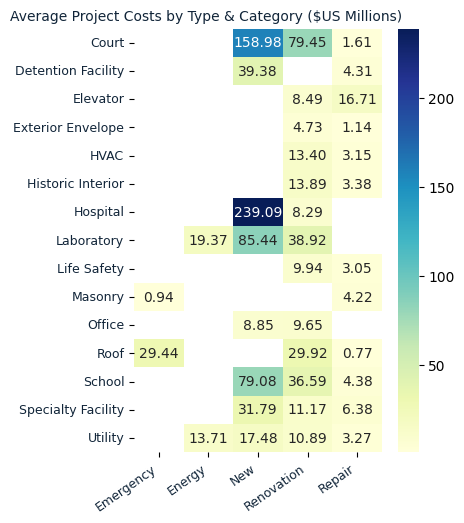

In [40]:
#Heatmap
plt.figure(figsize=(4, 5.5))
sns.heatmap(pivot_spendings, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Project Costs by Type & Category ($US Millions)", x = -0.5, ha='left', color='#112539', fontsize = 10)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 35, ha = "right", fontsize = 9, color='#112539')
plt.yticks(fontsize = 9, color='#112539')
plt.show()

The heatmap shows the average spending (in $US millions) for each combination of construction type and summarized category. Darker cells indicate higher costs. We can see that new projects cost on average more than repairs and renovations. With the majority of projects being renovations, a better glimpse into the averages is seen. Surprinsingly, the emergency projects do not seem as costly compared to other categories of roof projects.

It seems like the elevator repair costed twice as much as the renovation, perhaps because this elevator was located in a historic building. It is recommneded, to be replaced with a more modern elevator that does not need specialized services, if the law allows.

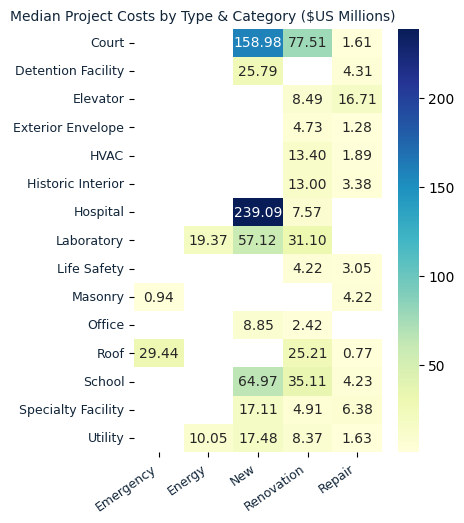

In [41]:
# What about the median price of most projects?
pivot_spendings2 = anca_summary.groupby(['construction_type', 'summarized_category'])['adjusted_tpc'].median().reset_index()
pivot_spendings2['adjusted_tpc'] = pivot_spendings2['adjusted_tpc']/1e6
pivot_spendings2 = pivot_spendings2.pivot(index = 'summarized_category', columns = 'construction_type', values = 'adjusted_tpc')

#Heatmap
plt.figure(figsize=(4, 5.5))
sns.heatmap(pivot_spendings2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Median Project Costs by Type & Category ($US Millions)", x = -0.5, ha='left', color='#112539', fontsize = 10)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 35, ha = "right", fontsize = 9, color='#112539')
plt.yticks(fontsize = 9, color='#112539')
plt.show()

This heatmap displays median project costs by construction type and bucket category, complementing the previous average cost view. The hospital prevails as the largest cost because there is only one new hospital project in the dataset. Looking at medians can reveal differences from the averages when there are large outliers or a skewed cost distribution. Some categories that had higher average costs may show lower medians, indicating that a few very expensive projects drove up their averages, such as Life Safety renovations, Office renovations, and new detention facility. Conversely, categories with more consistently priced projects, or unique instances, will have similar median and average values.

Towards what part of the project (%) does DCAMM spends 95% of the money for each project?

In [42]:
from dateutil.relativedelta import relativedelta #calculates months based on the calendar

PID = 'POL1501' # replace project ID here
selected_pid = detailed[detailed['PID'] == PID].copy() # this filters the data only by PID

# Sort data by date (oldest to newest)
selected_pid = selected_pid.sort_values(by = 'doc_last_modified_date')

# Compute cumulative spending
selected_pid['cumulative_spending'] = selected_pid['adjusted_cash_expense'].cumsum()

# Calculate the 95% spending threshold to find which date (month) corresponds
spending_threshold = 0.95 * selected_pid['adjusted_tpc']

# Identify the date when cumulative spending reaches 95%
pid_95pct = selected_pid[selected_pid['cumulative_spending'] >= spending_threshold].iloc[0] #we need only the first occurrence, there might be multiple afterwards

# Calculate project duration in months (you cannot add up the durations of the payclass bcs they overlap)
total_months = (selected_pid['doc_last_modified_date'].max().year - selected_pid['doc_last_modified_date'].min().year) * 12 + (selected_pid['doc_last_modified_date'].max().month - selected_pid['doc_last_modified_date'].min().month) +1
    # +/- one month due to lack of approximation.

# Determine 95% spending completion month
spending_95_date = pid_95pct['doc_last_modified_date']
spending_95_month = (spending_95_date.year - selected_pid['doc_last_modified_date'].min().year) * 12 + (spending_95_date.month - selected_pid['doc_last_modified_date'].min().month) +1
         # +/- one month due to lack of approximation.

# Normalize 95% spending as a percentage of project duration
spending_95_pct_completion = (spending_95_month / total_months) * 100

# Print results
print(f"95% Spendings reached on: {pid_95pct['doc_last_modified_date']}")
print(f"Project Duration: {total_months} months")
print(f"95% Spendings occurred at month: {spending_95_month} ({spending_95_pct_completion:.1f}%)")

95% Spendings reached on: 2017-02-16 00:00:00
Project Duration: 56 months
95% Spendings occurred at month: 27 (48.2%)


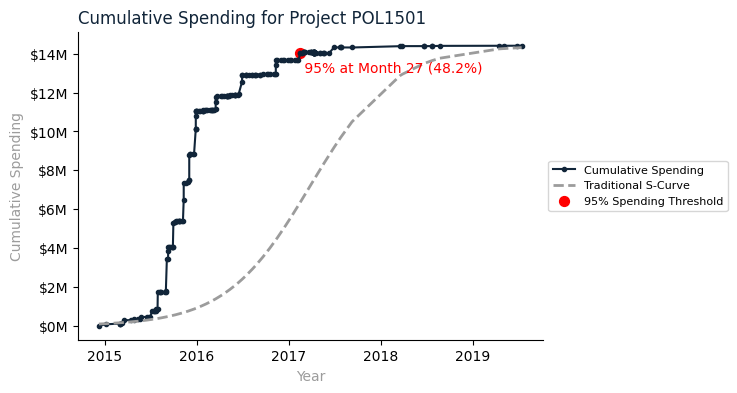

In [43]:
from scipy.special import expit  # sigmoid function for s-curve

# Convert dates to numeric values (e.g. days since start)
dates = selected_pid['doc_last_modified_date']
x = (dates - dates.min()).dt.days.values

# Parameters for S-curve
x_norm = (x - x.min()) / (x.max() - x.min())  # Normalize between 0 and 1
s_curve = expit(10 * (x_norm - 0.5))  # Adjust '10' to control steepness

# Scale S-curve to max cumulative spending
s_curve = s_curve * selected_pid['cumulative_spending'].max()

plt.figure(figsize=(6,4))
plt.plot(selected_pid['doc_last_modified_date'], selected_pid['cumulative_spending'], label = 'Cumulative Spending', color = '#112539',
         marker = 'o', markersize=3, linestyle = '-')

# Plot S-curve
plt.plot(dates, s_curve, color='#9C9C9C', linestyle="dashed", linewidth=2, label="Traditional S-Curve")

# Marking the 95% spending point
plt.scatter(pid_95pct["doc_last_modified_date"], pid_95pct["cumulative_spending"], 
            color="red", zorder=1, label="95% Spending Threshold", s=50)

# Annotate the 95% spending threshold
plt.text(pid_95pct['doc_last_modified_date'], pid_95pct['cumulative_spending'] * 0.93,
         f' 95% at Month {spending_95_month} ({spending_95_pct_completion:.1f}%)', color = 'red', fontsize = 10)

plt.xlabel("Year", color = '#9C9C9C')
plt.ylabel("Cumulative Spending", color = '#9C9C9C')
plt.title(f'Cumulative Spending for Project {PID}', x=0, ha = 'left', color='#112539')
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), fontsize = 8)

# Format y-axis labels as $xM
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${x/1e6:,.0f}M'))

sns.despine()

plt.show()

Individual projects can be visualized by simply changing the PID to the desired project. After looking at couple of projects, it was noticed that some projects do not follow the traditional S-curve associated with construction spendings. For instance, project S992 exhibited a sharp increase in spending early on, reaching the 95% spending threshold at just 18% of the total project duration. After reviewing the costs, the gym for the police officers acquired most of the equipment in the beginning of the project. In contrast, project POL1501 followed a more gradual spending trajectory, with 95% of expenditures occurring at 48% of the project timeline, aligning more closely with expected spending distributions, but still not the gradual increase as expected.

Next, these thresholds need to be stored in a dataset in order to create a summary and draw conclusions based on more data.

In [44]:
# Create a dataset with all 95% thresholds and completion rates.

threshold_data = []

for pid in detailed['PID'].unique():
    selected_pid = detailed[detailed['PID'] == pid].copy()
    selected_pid = selected_pid.sort_values(by = 'doc_last_modified_date')
    selected_pid['cumulative_spending'] = selected_pid['adjusted_cash_expense'].cumsum()
    spending_threshold = 0.95 * selected_pid['adjusted_tpc'].iloc[0]
    pid_95pct = selected_pid[selected_pid['cumulative_spending'] >= spending_threshold].iloc[0]

    #Calculate project duration in months
    total_duration_months = ((selected_pid['doc_last_modified_date'].max().year - selected_pid['doc_last_modified_date'].min().year) * 12
                    + (selected_pid['doc_last_modified_date'].max().month - selected_pid['doc_last_modified_date'].min().month)) + 1
    
    # Determine 95% spending completion month
    spending_95_date = pid_95pct['doc_last_modified_date']
    spending_95_month = (spending_95_date.year - selected_pid['doc_last_modified_date'].min().year) * 12 + (spending_95_date.month - selected_pid['doc_last_modified_date'].min().month) +1

    spending_95_pct_completion = round((spending_95_month / total_duration_months) * 100, 1)

    threshold_data.append({
        'PID': pid,
        "95pct_spending_date": pid_95pct['doc_last_modified_date'],
        "total_duration_months": total_duration_months,
        "spending_95_month": spending_95_month,
        'spending_95_pct_completion': spending_95_pct_completion
    })

threshold_data = pd.DataFrame(threshold_data)

In [45]:
# Bring in informational columns in the threshold dataset
threshold_data = threshold_data.merge(summary[['PID', 'construction_type', 'summarized_category', 'county', 'city']],
                                      left_on = 'PID', right_on= 'PID', how = 'left')
### this will need to be redone for bringing in extra columns

UMD1901 does not appear in the summary dataset, it sneaked it with the new data sets provided by DCAMM. The missing data will be inputed based on the info in cash expense dataset. Some informational columns will be brought back in the threshold dataset to create insightful graphs.

In [46]:
# Insert missing data for UMD1901
threshold_data.loc[threshold_data['PID'] == 'UMD1901', ['construction_type','summarized_category', 
                                                        'county', 'city']] = ['Renovation', 'School',
                                                                              'Bristol', 'Dartmouth']
# UMass is located in Boston, Suffolk county, but SENG building is in Dartmouth, MA
# Based on program_name this is a renovation

When does DCAMM spend 95% of the funds on average?

In [47]:
threshold_data.describe()

,95pct_spending_date,total_duration_months,spending_95_month,spending_95_pct_completion
count,158,158.000000,158.000000,158.000000
mean,2017-07-30 22:10:37.974683648,77.329114,55.018987,72.260127
min,2006-11-22 00:00:00,10.000000,7.000000,17.600000
25%,2015-10-08 06:00:00,41.250000,25.000000,60.275000
50%,2017-07-23 00:00:00,71.000000,52.000000,73.250000
75%,2019-07-29 12:00:00,110.250000,76.000000,86.525000
max,2023-06-28 00:00:00,209.000000,148.000000,100.000000
std,NaN,42.531883,32.202677,17.617001


On average, DCAMM reaches 95% of project spending at 71% of the total project duration, which corresponds to approximately month 54 in a typical project timeline. Moreover, it is more reasonable to look at the median, since it's not affected by outliers. The median is not that different than the average, 72.2%. This suggests that spending is generally weighted toward the middle stages of the project but is still distributed over an extended period.

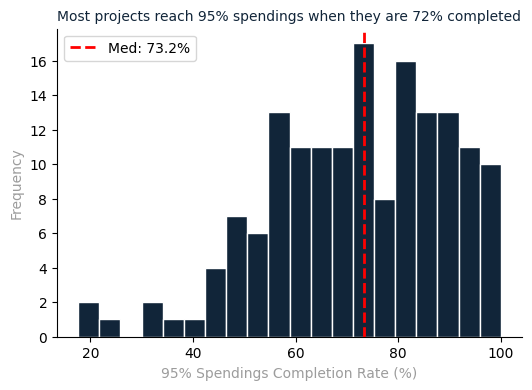

In [48]:
median_spending_95_pct = threshold_data['spending_95_pct_completion'].median()

plt.figure(figsize=(6, 4))
plt.hist(threshold_data["spending_95_pct_completion"], bins=20, color="#112539", edgecolor = "white")

# Add a vertical line for the average 95% spending completion percentage
plt.axvline(median_spending_95_pct, color="red", linestyle="dashed", linewidth=2, label=f"Med: {median_spending_95_pct:.1f}%")

# Formatting the plot
plt.xlabel("95% Spendings Completion Rate (%)", color = '#9C9C9C')
plt.ylabel("Frequency", color = '#9C9C9C')
plt.title("Most projects reach 95% spendings when they are 72% completed", size = 10, color='#112539', x = 0, ha = 'left')
plt.legend()
sns.despine()

# Show the plot
plt.show()

The histogram of 95% Spending Completion Percentage reveals several key insights about project spending patterns. The average completion rate is around 72% (marked by the red dashed line), indicating that many projects spend the funds well before 95% of the project was completed. The distribution is fairly wide, ranging from 20% to nearly 100%, with a notable concentration of projects between 60% and 90%, suggesting that while most projects progress well, a significant portion stall before reaching full completion. There is a clear peak around 80%, indicating a common stopping point. Additionally, a smaller but important subset of projects remains at very low completion rates (below 40%), which could point to funding issues, cancellations, or project delays.

Do the spending habits differ between construction types?

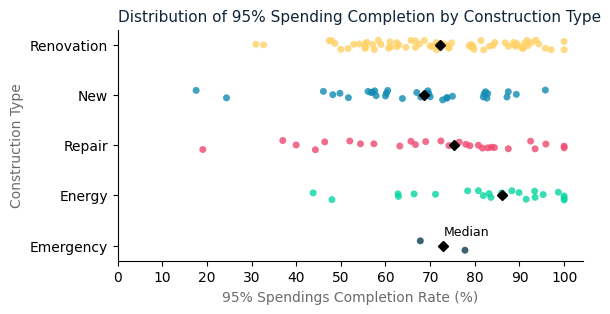

In [49]:
medians = threshold_data.groupby('construction_type')['spending_95_pct_completion'].median()
construction_order = threshold_data['construction_type'].unique()

plt.figure(figsize=(6,3))
sns.stripplot(data = threshold_data,
              x = 'spending_95_pct_completion',
              y = 'construction_type',
              hue = 'construction_type',
              dodge = False,
              jitter = True,
              palette=['#FFD166', '#118AB2','#EF476F','#06D6A0', '#073B4C'],
              alpha = 0.8)

for i, construction_type in enumerate(construction_order):
    median_val = medians[construction_type]
    plt.plot(median_val, i, marker = 'D', color = "black", markersize=5, label=None, zorder = 10) # zorder brings the Diamonds forefront

plt.title('Distribution of 95% Spending Completion by Construction Type', x = 0, ha ='left', color = '#112539', fontsize= 11)
plt.xlabel('95% Spendings Completion Rate (%)', color = '#6B6B6B')
plt.xticks(range(0, 110, 10))
plt.ylabel('Construction Type', color = '#6B6B6B')
plt.text(73, 3.8, 'Median', fontsize=9, color='black')

sns.despine()

plt.show()

The distribution of 95% spending completion rates by construction type includes black diamond markers indicating the median for each group. The plot reveals clear differences in spending behaviour across project types. 

Renovation projects show a relatively tight clustering in the upper range, with a median close to 70%, suggesting that spending is spread steadily across the project lifecycle. New and repair projects display more variation. The new projects median falls earlier, at about 60%, indicating that these projects tend to spend most of their budget earlier. The repair projects follow a similar pattern to renovations, but with a median completion rate of around 75%. The energy projects show a slower burn rate, with the median around 85%. Lastly, there are only two emergency projects, so a statement should not be drawn.

Overall, the graph suggests that construction type significantly influences the timing of 95% spendings, with new construction projects dispensing the budget sooner than other types. The diamond marker helps highlight central tendencies, serving as a useful reference point for planning and forecasting.

Does the mean 95% spending completion rates differ significantly between Renovation, New, and Repair projects?

In order to answer this question, hypothesis testing with ANOVA will be performed. The assumptions need to be checked before applying ANOVA.
1. Independce: Each project is an independent observation.
2. Normality: Each group should roughly follow a normal distribution.
3. Homogeneity of variance: Variance should be similar across groups.

In [50]:
# Test for assumptions

# Normality with Shapiro-Wilk Test
from scipy.stats import shapiro

# H0: Groups data is normally distributed.
# H1: Groups data are not normally distributed.


# Filter for target construction types
subset = threshold_data[threshold_data["construction_type"].isin(["Renovation", "New", "Repair"])]

# Group data
groups = subset.groupby("construction_type")["spending_95_pct_completion"]

# Shapiro-Wilk test for each group
for name, group in groups:
    stat, p = shapiro(group)
    print(f"{name}: W={stat:.3f}, p-value={p:.3f}")


New: W=0.946, p-value=0.094
Renovation: W=0.970, p-value=0.096
Repair: W=0.955, p-value=0.260


Because all of the p-values > 0.05, we fail to reject the null hypothesis, therefore the data is normally distributed.

Next, the homogeneity of variances will be tested with Levene's Test.

In [51]:
# Testing for Homogeneity of Variances (Levene's Test)
from scipy.stats import levene

# H0: The population variances are equal across groups. (p > 0.05)
# H1: At least one group has a different variance.

renovation = subset[subset['construction_type'] == 'Renovation']['spending_95_pct_completion']
new = subset[subset['construction_type'] == 'New']['spending_95_pct_completion']
repair = subset[subset['construction_type'] == 'Repair']['spending_95_pct_completion']

stat, p = levene(renovation, new, repair)
print(f"Levene's Test: W={stat:.3f}, p-value={p:.3f}")

Levene's Test: W=0.882, p-value=0.417


Because p > 0.05 (0.396), the variances are equal.

With the last assumption checked, the ANOVA test can be safely performed.

In [52]:
# One-Way ANOVA
from scipy.stats import f_oneway

# H0: There is no significant difference in the mean 95% spending completion rates among Renovation, New, and Repair projects.
# H1: At least one group's mean 95% spending completion rate is significantly different from the others.
#If p < 0.05, there is a statistically significant difference in the mean 95% completion rates across the three types.	

f_stat, p_value = f_oneway(renovation, new, repair)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

F-statistic: 1.5141
P-value: 0.2239


A higher F-statistic indicates a greater likelihood that group means are different. Because the p-value = 0.0094, which is less than 0.05, the null hypothesis is rejected. Therefore, there is a statistically significant difference in the mean 95% spending completion rates between at least one pair of project types.

Which pairs of the project types differ in their mean?

In [53]:
# Tukey's HSD (Honestly Significant Difference) test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_result = pairwise_tukeyhsd(endog=subset['spending_95_pct_completion'],
                                 groups= subset['construction_type'],
                                 alpha = 0.05)

print(tukey_result.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------
       New Renovation   6.3436 0.1948  -2.3064 14.9937  False
       New     Repair   4.5229 0.5684  -6.0372  15.083  False
Renovation     Repair  -1.8207 0.8871 -11.0736  7.4321  False
-------------------------------------------------------------


The table can be interpreted as if p<0.05 then the difference is statistically true, or if the lower-upper interval contains 0.

To better understand how spending patterns differ between types of projects, the average point in the project timeline when 95% of funds are spent was compared across Renovation, New, and Repair projects. Using statistical tests designed to compare groups, the following were found:
- New projects tend to spend their budgets much earlier than renovation projects (p<0.05). The difference is statistically significant, meaning it's unlikely to be due to random chance. New projects reach 95% of their spending about 11 percentage points earlier than renovation projects.
- While new projects also reach 95% spending earlier than repair projects, the difference is not strong enough to be considered statistically significant, so it cannot be said for sure that these two groups are meaningfully different.
- Renovation and repair projects have very similar patterns, with no meaningful difference in how quickly they reach 95% of spending.


In [54]:
summary_stats_completion = ( threshold_data.groupby('summarized_category')['spending_95_pct_completion'].agg([
    'count', lambda x: x.quantile(0.25), 'mean', 'median', lambda x: x.quantile(0.75), 'std', 'min', 'max'
]).rename(columns= {
    "<lambda_0>": "P25",
    "<lambda_1>": "P75"
    }).reset_index().round(2)
)

summary_stats_completion

,summarized_category,count,P25,mean,median,P75,std,min,max
0,Court,7,67.60,80.04,89.20,92.30,16.24,55.4,95.9
1,Detention Facility,5,57.60,70.94,60.00,87.20,17.39,57.4,92.5
2,Elevator,3,71.60,75.50,76.50,79.90,8.35,66.7,83.3
3,Exterior Envelope,5,67.60,80.56,74.20,94.30,15.55,66.7,100.0
4,HVAC,6,46.82,60.75,63.30,77.23,20.90,31.0,83.7
5,Historic Interior,5,55.80,69.96,74.20,79.10,15.62,52.0,88.7
6,Hospital,6,59.50,72.20,74.05,83.72,17.08,49.8,93.7
7,Laboratory,17,60.50,70.16,70.00,74.80,13.00,48.7,95.8
8,Life Safety,5,78.70,76.14,84.10,87.50,20.67,40.0,90.4
9,Masonry,3,77.90,80.07,78.00,81.20,3.75,77.8,84.4


In [55]:
summary_stats_completion.rename(columns={"summarized_category": "Summarized Category"}) \
    .style \
    .set_caption("Summary Statistics of 95% Spendings Completion by Category") \
    .background_gradient(cmap="Blues", subset=["mean", "median", "std"]) \
    .format("{:.2f}", subset= summary_stats_completion.select_dtypes(include = "number").columns) \
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "11pt"), ("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "12pt"), ("font-weight", "bold")]}
    ]) \
    .set_properties(**{"text-align": "center"})

,Summarized Category,count,P25,mean,median,P75,std,min,max
0,Court,7.00,67.60,80.04,89.20,92.30,16.24,55.40,95.90
1,Detention Facility,5.00,57.60,70.94,60.00,87.20,17.39,57.40,92.50
2,Elevator,3.00,71.60,75.50,76.50,79.90,8.35,66.70,83.30
3,Exterior Envelope,5.00,67.60,80.56,74.20,94.30,15.55,66.70,100.00
4,HVAC,6.00,46.82,60.75,63.30,77.23,20.90,31.00,83.70
5,Historic Interior,5.00,55.80,69.96,74.20,79.10,15.62,52.00,88.70
6,Hospital,6.00,59.50,72.20,74.05,83.72,17.08,49.80,93.70
7,Laboratory,17.00,60.50,70.16,70.00,74.80,13.00,48.70,95.80
8,Life Safety,5.00,78.70,76.14,84.10,87.50,20.67,40.00,90.40
9,Masonry,3.00,77.90,80.07,78.00,81.20,3.75,77.80,84.40


Based on the summary statistics, an overview about how different project categories behave in terms of reaching 95% of their total spending can be seen. 

Detention facility projects stand out with the lowest median (37.8%), lowest mean (53.74%), and high standard deviation, indicating these projects often reach 95% spendings, and there is large variation between the projects. HVAC projects also lean earlier, with relatively low 25th percentile (46.82%), and median (63.3%), suggesting that these projects spend heavily up front. This makes sense for HVAC projects, because the equipment could be ordered and partially paid in advance. Because of the high standard deviation for both of these categories (20+), it can be drawn that the spending patterns are inconsistent, likely due to differences in project scope, urgency, or timeline.

Roof, Office, and Court projects show high means and median (80%+), implying that spending is distributed more evenly across the project timeline.

Mansory shows extremely low variability (std = 3.75), with close percentiles, which indicates consistent and phased delivery approach.

Another way to visualize these results is through a boxplot.

C:\Users\Anca\AppData\Local\Temp\ipykernel_26968\985975323.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=threshold_data, x="spending_95_pct_completion", y="summarized_category",
C:\Users\Anca\AppData\Local\Temp\ipykernel_26968\985975323.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


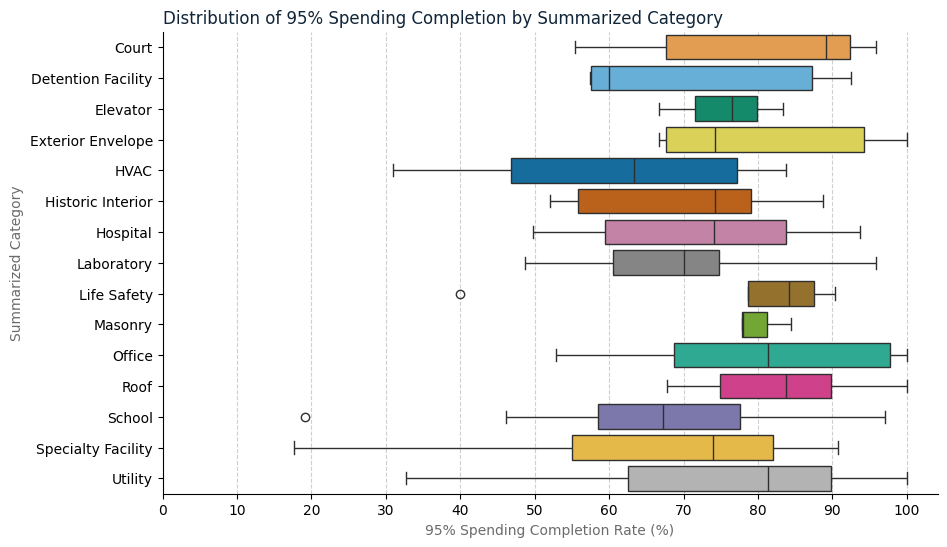

In [56]:
# Colorblind friendly palette
custom_palette_15 = [
    "#FA9E3A",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
    "#858585",  # medium gray
    "#A6761D",  # brown
    "#73BA22",  # olive green
    "#1BBD9D",  # teal
    "#E7298A",  # pink
    "#7570B3",  # purple-blue
    "#FFC42F",  # bright yellow
    "#B3B3B3",  # light gray
]

# Set up the plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=threshold_data, x="spending_95_pct_completion", y="summarized_category", 
            palette=custom_palette_15,
            order = sorted(threshold_data['summarized_category'].unique()))

# Formatting
plt.xlabel("95% Spending Completion Rate (%)", color = '#6B6B6B')
plt.xticks(range(0, 110, 10))
plt.ylabel("Summarized Category", color = '#6B6B6B')
plt.title("Distribution of 95% Spending Completion by Summarized Category", color = '#112539',
          x= 0, ha = 'left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend().set_visible(False)

sns.despine()


# Show the plot
plt.show()

The boxplot above illustrates how the 95% spending completion rates are distributed across various project categories in the same manner as the summary statistics table. Each horizontal bar represents the range in which most projects of a certain type reach 95% of their total spending, with the vertical lines (whiskers) showing the full spread of the data, and the dots indicating outliers — projects that behaved unusually compared to the rest.

Notably, some categories such as Roof, Masonry, and Elevator show a tight distribution clustered toward the higher end of the timeline, suggesting that these projects typically reach 95% of their spending late in the project duration and do so consistently. In contrast, categories like HVAC, Specialty Facilities, and Detention Facilities have a broader range, indicating more variation in when major spending takes place.

Outliers are also evident in several categories. For example, Detention Facilities, Life Safety, and School projects each contain projects that reached 95% spending either unusually early or late compared to the norm. These outliers may reflect unique funding strategies, project delays, or unusual scopes of work.

This visualization not only helps highlight typical spending behavior within each category but also reveals which types of projects tend to be more predictable versus those that are more variable or exceptional in their spending patterns. Such insights can inform planning, budgeting, and risk assessment across future capital projects.

All in all, it begs the question, why do some of the projects take so long to pay the remaining 5% after the 95% spending threshold was reached so early in the project?

How many vendors on average per project exist? Is one vendor more prevalent?

In [57]:
# Count the number of unique vendors per project
vendors_per_project = detailed.groupby("PID")["legal_name"].nunique()

# Calculate the average
average_vendors = vendors_per_project.mean()


# Count how many unique projects each vendor worked on
vendor_project_counts = detailed.groupby("legal_name")["PID"].nunique()

# Sort vendors by number of projects (most to least)
most_common_vendors = vendor_project_counts.sort_values(ascending=False)

print(f"Average number of vendors per project: {average_vendors:.2f}")

# Display the top 10
print(most_common_vendors.head(5))

Average number of vendors per project: 16.66
legal_name
BOSTON HERALD INC                57
CREATIVE OFFICE INTERIORS INC    43
W. B MASON CO INC                42
BANNER PUBLICATIONS INC          35
BACSON BLUEPRINT INC             31
Name: PID, dtype: int64


On average, each project involves approximately 17 different vendors, reflecting the collaborative and multi-disciplinary nature of DCAMM’s capital projects. Among the vendors, a few stand out due to their repeated engagement across numerous projects. Boston Herald Inc is the most frequently involved, having contributed to 57 distinct projects. Creative Office Interiors Inc follows closely with participation in 43 projects, demonstrating consistent involvement in furnishing or interior solutions. W.B. Mason Co. also ranks among the top vendors with 42 projects completed.

### Machine Learning Models on Summary Dataset
Note: The total project cost is not predicted on inflation-adjusted total cost.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim

In [59]:
# Prepare for models

# Fill missing numerical values with 0
col_missing_values = [
    'land_acquisition_costs_final',
    'dur_land_acq_months',
    'fe_costs_final',
    'dur_fe_months',
    'design_costs_final',
    'dur_design_months',
    'dur_other_months',
    'other_costs_final']

anca_summary[col_missing_values] = anca_summary[col_missing_values].fillna(0)

# Confirm that missing values are handled
anca_summary.isnull().sum()

PID                             0
construction_type               0
summarized_category             0
phase                           0
county                          0
city                            0
con_month_95pct_spent           0
adjusted_tpc                    0
total_project_cost              0
total_duration_months           0
design_costs_final              0
dur_design_months               0
construction_costs_final        0
dur_construction_months         0
land_acquisition_costs_final    0
dur_land_acq_months             0
fe_costs_final                  0
dur_fe_months                   0
dur_other_months                0
other_costs_final               0
dtype: int64

#### Artificial Neural Networks (ANN)

In [60]:
# 1
#ann_data = anca_summary.drop(columns=['PID', 'total_duration_months', "adjusted_tpc"]) #total duration if included would cause multicolinearity
#
# 2
#ann_data = anca_summary.drop(columns=['PID', 'total_duration_months', "adjusted_tpc",
 #                                    'city', "county"])


# 3
ann_data = anca_summary.drop(columns=['PID', 'total_duration_months', "adjusted_tpc",
                                     'city', "county", "phase"])


#4 Remove all categorical
#ann_data = anca_summary.drop(columns=['PID', 'total_duration_months', "adjusted_tpc",
    #                                  'city', "county", "phase", "construction_type", "summarized_category"])

# 5 Remove all cost-related columns
#ann_data = anca_summary.drop(columns=['PID', 'total_duration_months', "adjusted_tpc",
#                                          'design_costs_final', 'construction_costs_final', 'land_acquisition_costs_final',
 #                                         'fe_costs_final', 'other_costs_final']) 
# one-hot encoding creates too many variable, and due to the sheer number of projects, a good r2 is not achieved. City and County should be removed.

Setting the missing values to 0 for the projects that do not contain land acquisition costs and furniture is the most logical and accurate approach. These projects genuinely didn't include these activities.

In [61]:
# One-hot encoding for categorical variables
categ_cols = ann_data.select_dtypes(include = ['object']).columns.tolist()
encoded_data = pd.get_dummies(ann_data, columns=categ_cols, drop_first=True)

In [62]:
# Remove the target variable
X = encoded_data.drop('total_project_cost', axis = 1)
y = encoded_data['total_project_cost']

In [63]:
# Split data into training and testing (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=73)

In [64]:
# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Display the dimensions of the processed datasets
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((125, 29), (32, 29), (125,), (32,))

In [65]:
# Scale the target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

In [66]:
# ANN Model (MLPRegressor)
ann_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation = 'relu',
                         solver = 'adam', max_iter=10000, early_stopping=True, random_state= 103)

# Train the model
ann_model.fit(X_train_scaled, y_train_scaled)

# Predict
y_pred_ann = ann_model.predict(X_test_scaled)

In [67]:
print(f"Mean Absolute Error (MAE): {round(mean_absolute_error(y_test_scaled, y_pred_ann), 4)}")
print(f"Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_scaled, y_pred_ann)), 4)}") #standardized targets, an RMSE under 0.5 is generally a good sign of performance.
print(f"Mean Absolute Percentage Error (MAPE): {round(mean_absolute_percentage_error(y_test_scaled, y_pred_ann), 4)}")
print(f"R2: {round(r2_score(y_test_scaled, y_pred_ann), 2)}")

Mean Absolute Error (MAE): 0.2064
Root Mean Squared Error (RMSE): 0.302
Mean Absolute Percentage Error (MAPE): 0.5941
R2: 0.89


Test1. Multiple versions of ANN were performed in order to figure out which features are relevant to the model performance. Initially, the model underperformed, likely due to limited training data (70%) and insufficient epochs (1000 iterations). After increasing to 80% training and 10,000 iterations, performance improved significantly (RMSE = 0.491, R² = 0.70).

Test2. Two predictors were removed: city & county. Now the RMSE = 0.3256 and R² = 0.8670. For standardized targets, an RMSE under 0.5 is generally a good sign of performance. The city and county could have introduced overfitting, especially when one-hot encoded with many unique values.

Test3. Three predictors were removed: city, county, phase. Now the RMSE = 0.302 and R² = 0.89. R2 better than before.

Test4. When all character variables were removed, performance declined slightly (RMSE = 0.5816, R² = 0.58), suggesting that the one-hot encoded features contributed limited predictive value. These variables may have introduced more complexity than signal, making them less effective for this model.

Test5. All the breakout costs were removed, and the results are: RMSE = 0.7417 and R² = 0.31. This is a significant decrease in the ANN model because half of the 'qualitative' predictors were removed. The model is likely leveraging the direct relationship between them and total project cost.

It is noticed that when the caracter variables are removed, the measures decreased only slightly, which signifies that the one-hot encoding variables introduce complexity and noise. Additionally, since construction cost + land acquisition cost + fe cost+ other cost = total project cost, this model is not actually predicting, but it's learning an already-defined mathematical relationship. To have a truly predictive model, pre-project variables should be used instead, such as building specifications (number of rooms, square footage, number of floors, etc.).

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ann', MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', validation_fraction=0.2, n_iter_no_change=50,
                         solver = 'adam', max_iter= 10000, early_stopping=True, random_state= 103))
])

cv_scores = cross_val_score(pipeline, X, y, cv = 5, scoring='r2')

print(f"Mean cross-validation score: {round(np.mean(cv_scores), 2)}")
print(f"St. Dev. cross-validation score: {round(np.std(cv_scores),2)}")


Mean cross-validation score: -0.62
St. Dev. cross-validation score: 0.26


In [69]:
# Calculate adjusted R²
n = X_test_scaled.shape[0]  # Number of test samples
p = X_test_scaled.shape[1]  # Number of features

print( 1 - (1 - r2_score(y_test_scaled, y_pred_ann)) * ((n - 1) / (n - p - 1)))

-0.773517897136117


Adjusted R² assumes that the number of samples 

n is substantially larger than the number of predictors p.

In this case:

Test samples n=32

Predictors p=97

In [70]:
del col_missing_values, categ_cols, ann_data, pivot_spendings, pivot_spendings2, n, p

#### Random Forest

In [71]:
# Create and train the model
rf_model = RandomForestRegressor(
    n_estimators=100,      # number of trees
    max_depth=None,        # maximum depth of trees
    min_samples_split=2,   # minimum samples required to split
    min_samples_leaf=1,    # minimum samples required at a leaf node
    random_state=42        # for reproducibility
)

rf_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

In [72]:
print(f"Mean Absolute Error (MAE): {round(mean_absolute_error(y_test_scaled, y_pred_rf), 4)}")
print(f"Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_scaled, y_pred_rf)), 4)}") #standardized targets, an RMSE under 0.5 is generally a good sign of performance.
print(f"Mean Absolute Percentage Error (MAPE): {round(mean_absolute_percentage_error(y_test_scaled, y_pred_rf), 4)}")
print(f"R2: {round(r2_score(y_test_scaled, y_pred_rf), 2)}")

Mean Absolute Error (MAE): 0.2184
Root Mean Squared Error (RMSE): 0.2881
Mean Absolute Percentage Error (MAPE): 0.8488
R2: 0.9


In [73]:
# If X is your feature DataFrame, get the column names
feature_names = X.columns.tolist()

# Feature importance
feature_importance = pd.DataFrame(
    {'Feature': feature_names, 'Importance': rf_model.feature_importances_}
).sort_values('Importance', ascending=False)

# Print only the top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                         Feature  Importance
3       construction_costs_final    0.326041
7                 fe_costs_final    0.247310
1             design_costs_final    0.240498
4        dur_construction_months    0.057924
9               dur_other_months    0.041155
10             other_costs_final    0.037285
2              dur_design_months    0.034087
20  summarized_category_Hospital    0.005769
8                  dur_fe_months    0.004774
0          con_month_95pct_spent    0.002526


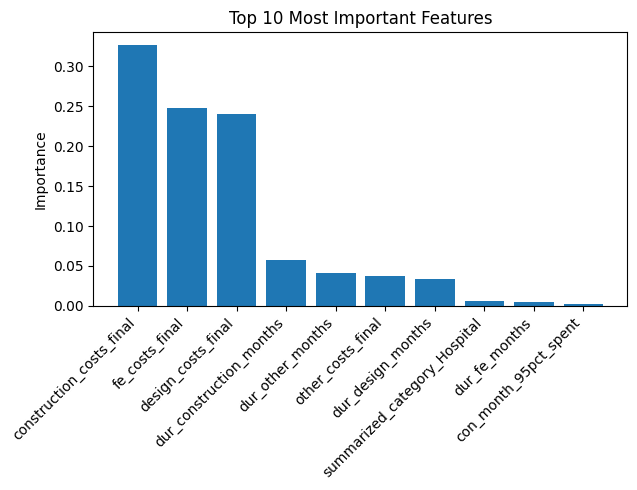

In [74]:
# Create a bar plot of the top 10 features
plt.figure(figsize=(6.5, 5))
top_10_features = feature_importance.head(10)
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.title('Top 10 Most Important Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\Anca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\inspection\_plot\partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


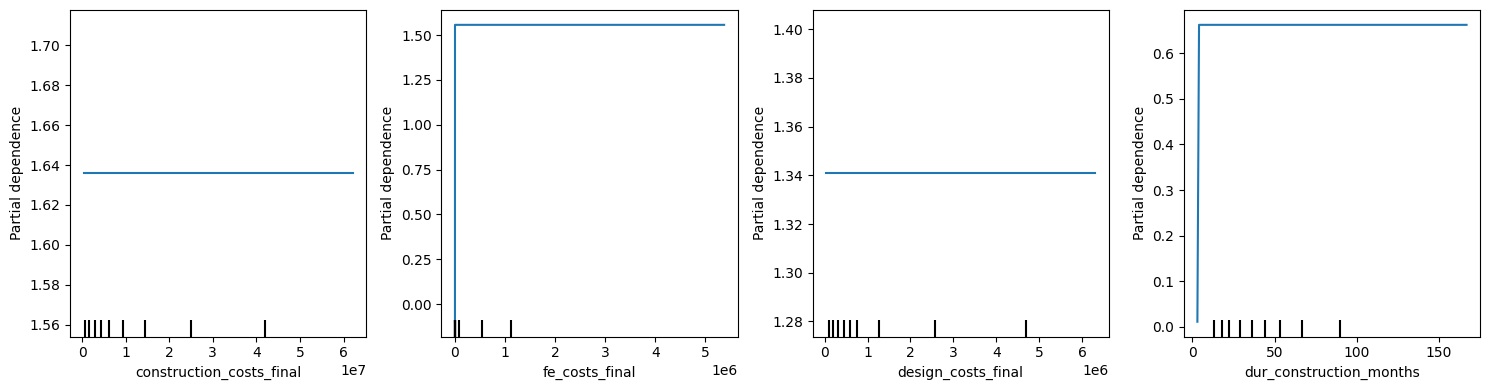

In [75]:
from sklearn.inspection import PartialDependenceDisplay

# Feature importance
feature_importance = pd.DataFrame(
    {'Feature': feature_names, 'Importance': rf_model.feature_importances_}
).sort_values('Importance', ascending=False)

# Get top features that actually exist in the dataset
top_features = feature_importance.head(4)['Feature'].tolist()
valid_features = [f for f in top_features if f in X_train.columns]

# Create subplots dynamically based on valid features
fig, ax = plt.subplots(figsize=(15, 4), ncols=len(valid_features))
ax = ax.flatten() if len(valid_features) > 1 else [ax]

for i, feature in enumerate(valid_features):
    PartialDependenceDisplay.from_estimator(rf_model, X_train, features=[feature], ax=ax[i])

plt.tight_layout()
plt.show()

The partial dependence plots show the marginal effect of each feature on the predicted outcome. All four features—construction_costs_final, fe_costs_final, design_costs_final, and dur_construction_months—appear to have little to no influence on the model's predictions, as indicated by the flat lines across the plots. This suggests the model's output does not vary significantly with changes in these features within the observed range.

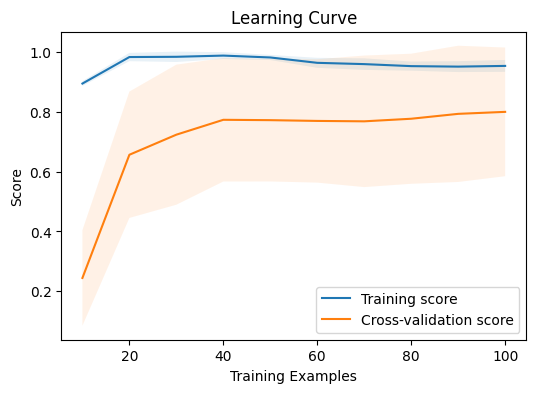

In [76]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()

The learning curve indicates that the model performs very well on the training data, maintaining a high training score close to 1.0. However, the cross-validation score is notably lower, especially with fewer training examples, suggesting potential overfitting. As the number of training examples increases, the gap between training and validation performance narrows slightly, but a moderate bias-variance issue remains.

#### Linear Model

In [77]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_scaled)

# Predict using Linear Regression
y_pred_lr = lr_model.predict(X_test_scaled)

In [78]:
print(f"Mean Absolute Error (MAE): {round(mean_absolute_error(y_test_scaled, y_pred_lr), 4)}")
print(f"Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_scaled, y_pred_lr)), 4)}") #standardized targets, an RMSE under 0.5 is generally a good sign of performance.
print(f"Mean Absolute Percentage Error (MAPE): {round(mean_absolute_percentage_error(y_test_scaled, y_pred_lr), 4)}")
print(f"R2: {round(r2_score(y_test_scaled, y_pred_lr), 2)}")

Mean Absolute Error (MAE): 0.2649
Root Mean Squared Error (RMSE): 0.3152
Mean Absolute Percentage Error (MAPE): 1.0722
R2: 0.88


#### XGBoost

In [79]:
# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=102)
xgb_model.fit(X_train_scaled, y_train_scaled)

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [80]:
print(f"Mean Absolute Error (MAE): {round(mean_absolute_error(y_test_scaled, y_pred_xgb), 4)}")
print(f"Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_scaled, y_pred_xgb)), 4)}") #standardized targets, an RMSE under 0.5 is generally a good sign of performance.
print(f"Mean Absolute Percentage Error (MAPE): {round(mean_absolute_percentage_error(y_test_scaled, y_pred_xgb), 4)}")
print(f"R2: {round(r2_score(y_test_scaled, y_pred_xgb), 2)}")

Mean Absolute Error (MAE): 0.1686
Root Mean Squared Error (RMSE): 0.2316
Mean Absolute Percentage Error (MAPE): 0.8128
R2: 0.93


### Machine Learning Models on Detailed Dataset
#### Decision Tree

The dataset used for the Random Forest model is a project-level summary where each row represents a distinct project and each column corresponds to a specific type of project charge based on the object_name (e.g., engineering services, equipment, salaries). These columns contain the actual amounts spent on each charge category, aggregated from detailed expense records. The target variable, tpc_category, indicates the tier of project expenses ($0 to $10 Million).

In [81]:
# Pivot the table
pivot_amounts = detailed.pivot_table(
    index="PID",
    columns="object_name",
    values="adjusted_cash_expense",
    aggfunc="sum",
    fill_value=0
).reset_index()

# Merge with summary to get tpc_category
decision_tree_df = pivot_amounts.merge(summary[["PID", "tpc_category"]],
                                left_on="PID", right_on="PID", how="left")

# Add the tpc_category for the newest project UMD9101
print(detailed[detailed['PID'] == "UMD1901"]['adjusted_tpc'].unique()) # 31Millions, which belongs to tpc_category = 3

decision_tree_df.loc[decision_tree_df['PID'] == "UMD1901", "tpc_category"] = 3

decision_tree_df.drop(columns="PID", inplace=True)

[30901050.8]


,precision,recall,f1-score,support
1.0,1.00000,0.933333,0.965517,15.000
2.0,0.75000,1.000000,0.857143,6.000
3.0,1.00000,0.666667,0.800000,3.000
4.0,0.75000,1.000000,0.857143,6.000
5.0,0.00000,0.000000,0.000000,2.000
accuracy,0.87500,0.875000,0.875000,0.875
macro avg,0.70000,0.720000,0.695961,32.000
weighted avg,0.84375,0.875000,0.849015,32.000


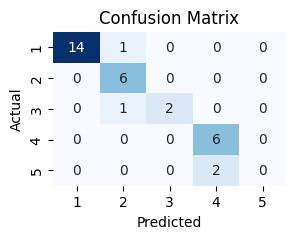

In [82]:
# Separate features and target
X = decision_tree_df.drop(columns=['tpc_category'])
y = decision_tree_df['tpc_category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

# Initialize and train Random Forest Classifier
forest = RandomForestClassifier(class_weight='balanced', random_state=73) #balanced bcs the dataset has fewer obs for some categories
forest.fit(X_train, y_train)

# Predictions and evaluation
y_pred = forest.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report = pd.DataFrame(report).transpose()
conf_matrix = confusion_matrix(y_test, y_pred)

display(report)

plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels= [1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Based on the results and the confusion matrix, the accuracy of this model is 87.5%, which is considered pretty good. Other few insights can be drawn:
- $0 to $10 Million (1):	Very strong performance - precision = 1.00, recall = 0.93. Only one project was misclassified as category 2.
- $10 to $25 Million (2): Perfect recall (1.00), which means all actual class 2 were correctly identified, though one class 1 was wrongly predicted as class 2.
- $25 to $50 Million (3): Precision = 1.00, but recall = 0.67- the model missed one actual class 3 and predicted it as class 2.
- $50 to $100 Million (4): Great recall (1.00), precision = 0.75 - one project from class 3 was wrongly classified here.
- $100 to $150 Million (5): Model failed to predict this class (precision and recall = 0) - both projects in this category were classified as class 4. This is due to very few training samples in this range.

In [83]:
print(f"Mean Absolute Error (MAE): {round(mean_absolute_error(y_test, y_pred), 4)}")
print(f"Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mean_absolute_percentage_error(y_test, y_pred), 4)}")
print(f"R2: {round(r2_score(y_test, y_pred), 2)}")

Mean Absolute Error (MAE): 0.125
Root Mean Squared Error (RMSE): 0.3536
Mean Absolute Percentage Error (MAPE): 0.0542
R2: 0.93


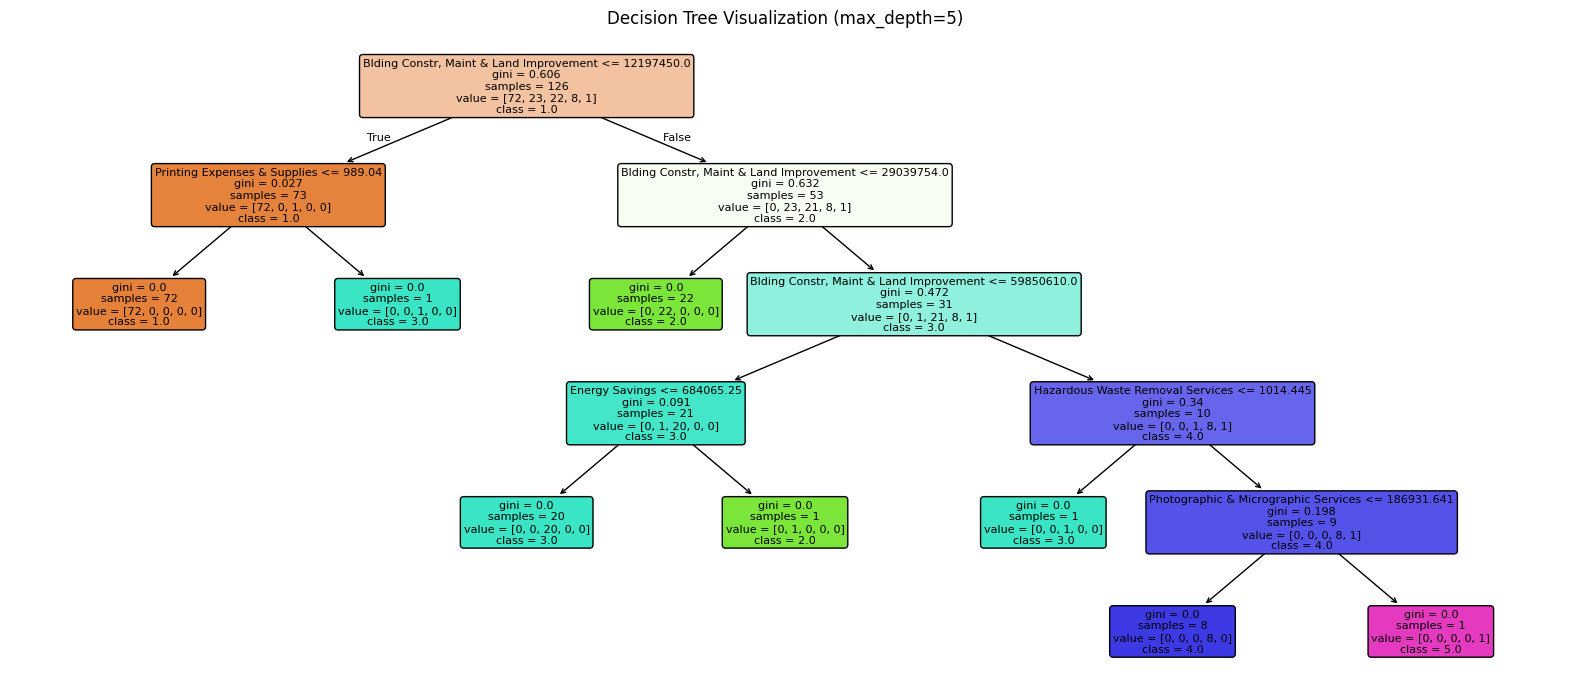

In [84]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Fit a simpler decision tree for visualization purposes
simple_tree = DecisionTreeClassifier(max_depth=5, random_state=73)
simple_tree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 8.5))
plot_tree(simple_tree, feature_names=X.columns, class_names=[str(c) for c in sorted(y.unique())],
          filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Visualization (max_depth=5)")
plt.show()

At its core, the model evaluates each project by sequentially assessing whether specific types of expenses exceed or fall below certain threshold values.

The decision process begins at the top node, where the model first considers whether the project’s spending on “Building Construction, Maintenance & Land Improvement” is less than approximately $12.2 million. Projects falling below this threshold are overwhelmingly classified into the lowest cost category, $0 to $10 million, indicating that this expense category is a strong initial indicator of project scale.

For projects exceeding that amount, the tree branches further, incorporating additional spending categories to refine its classification. For example, the model evaluates expenditures such as “Energy Savings,” “Hazardous Waste Removal Services,” and “Photographic & Micrographic Services” to distinguish between mid- and high-cost projects. These deeper nodes help the model differentiate more nuanced cases, such as distinguishing between projects in the $25 to $50 million and $50 to $100 million ranges, or identifying rare high-value projects in the $100 to $150 million category.

Each terminal node (leaf) of the tree represents a final decision about a project’s TPC category. These decisions are based on the historical distribution of similar projects and their associated expenditures. The decision tree thus serves not only as a predictive model but also as an interpretable framework for understanding how different combinations of expenses contribute to overall project cost classification.

In [85]:
importances = forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)

                                              Feature  Importance
4             Blding Constr, Maint & Land Improvement    0.270656
7         Engineering, Research & Scientific Services    0.159764
0                                Advertising Expenses    0.078316
14                   Hazardous Waste Removal Services    0.065919
28               Photographic & Micrographic Services    0.064423
13                    Furnishing & Maintenance/Repair    0.056491
11                                    Fringe Benefits    0.045881
17                                        IT Services    0.030850
26  Non-Major Facility Infrastructure Maintenance ...    0.027839
1                                Architects/Designers    0.026100
32                             Settlements/Judgements    0.021338
15                                            Highway    0.019154
30                              Professional Services    0.018612
36                                       Travel/Other    0.017886
27        

### Models Comparison

In [86]:
results = []

# Define a function to evaluate a model and add results to the list
def evaluate_model(model_name, y_true, y_pred):
    results.append({
        "Model": model_name,
        "MAE": round(mean_absolute_error(y_true, y_pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 4),
        "MAPE": round(mean_absolute_percentage_error(y_true, y_pred), 4),
        "R²": round(r2_score(y_true, y_pred), 2)
    })

In [87]:
evaluate_model("Linear Regression (Summary Data)", y_test_scaled, y_pred_lr)
evaluate_model("Random Forest (Summary Data)", y_test_scaled, y_pred_rf)
evaluate_model("XGBoost (Summary Data)", y_test_scaled, y_pred_xgb)
evaluate_model("ANN (Summary Data)", y_test_scaled, y_pred_ann)

evaluate_model("Random Forest (Detailed Dataset)", y_test, y_pred)

# Create a DataFrame from results
results_models = pd.DataFrame(results)

### Conclusions
This analysis compared predictive models using two types of datasets: one with summarized expense categories and another with highly detailed financial data. The summary dataset aggregated project expenses into broader categories such as construction, design, land acquisition, and furniture & equipment. Because these categories varied significantly in scale, the target variable was standardized to make patterns more comparable. Despite this transformation, models such as XGBoost and Artificial Neural Networks (ANN) performed well, demonstrating strong predictive accuracy.

The detailed dataset, in contrast, retained expense information down to the cent and categorized costs by specific charge types such as advertising and hazardous waste removal. The Random Forest model trained on this data showed the highest performance, with strong accuracy metrics even without standardizing the target. However, this result should be interpreted with caution. Many of the detailed charges directly contribute to the overall project cost, which raises the possibility of overfitting or data leakage—where the model learns to “predict” the target using inputs that already contain it. While the model performs well on this dataset, its ability to generalize to new, unseen data may be limited unless the same level of detailed cost information is available in advance.